# Применение ансамблевых моделей на базе решающих деревьев в задачах классификации 

## Подготовим среду и данные для выполнения заданий

### Импортируем необходимые библиотеки

In [ ]:
!pip install xgboost

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Загружаем датасет с информацией о медицинских параметрах больных диабетом

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabh00007/diabetescsv")

print("Path to dataset files:", path)

Path to dataset files: /home/sasha/.cache/kagglehub/datasets/saurabh00007/diabetescsv/versions/1


In [10]:
!ls $path

diabetes.csv


In [11]:
df = pd.read_csv(path + '/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
target = df['Outcome']
print(f'Размеры датасета: {df.shape}')

Размеры датасета: (768, 9)


In [13]:
X = df.drop('Outcome', axis=1)

# Разделяем на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42, stratify=target  # сохраняем пропорции классов
)

## 1) Random Forest: качество от глубины дерева

In [14]:
depths = range(1, 21)
acc_scores = []

for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))

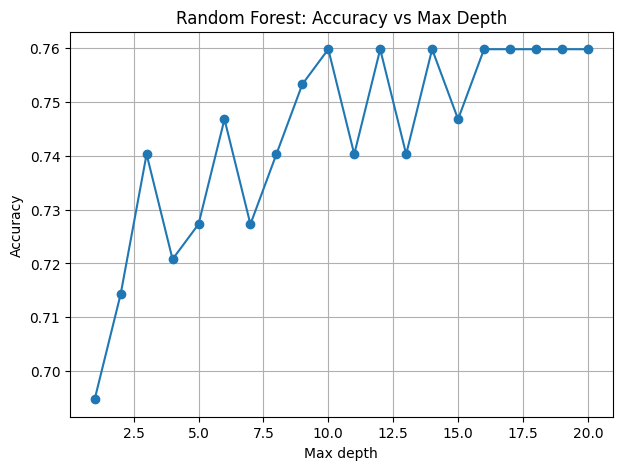

Оптимальная глубина дерева: 10
Максимальная точность: 0.7597402597402597


In [15]:
plt.figure(figsize=(7,5))
plt.plot(depths, acc_scores, marker='o')
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.title("Random Forest: Accuracy vs Max Depth")
plt.grid()
plt.show()

best_depth = depths[np.argmax(acc_scores)]
print("Оптимальная глубина дерева:", best_depth)
print("Максимальная точность:", max(acc_scores))

## 2) Random Forest: качество от max_features

In [16]:
max_features_values = range(1, X_train.shape[1]+1)
acc_scores_mf = []

for mf in max_features_values:
    clf = RandomForestClassifier(max_depth=best_depth, max_features=mf, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_scores_mf.append(accuracy_score(y_test, y_pred))

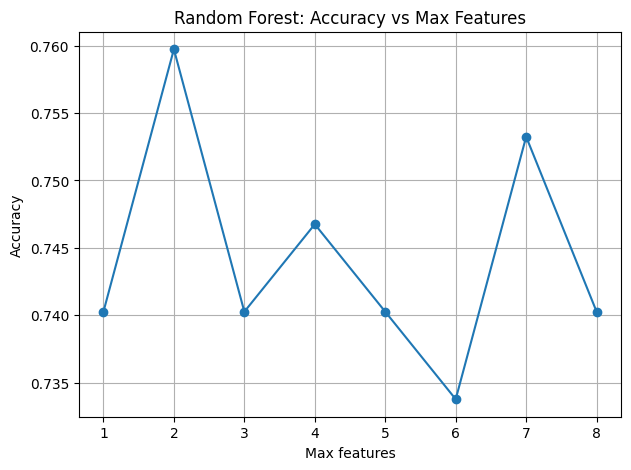

Оптимальное max_features: 2
Максимальная точность: 0.7597402597402597


In [17]:
plt.figure(figsize=(7,5))
plt.plot(max_features_values, acc_scores_mf, marker='o')
plt.xlabel("Max features")
plt.ylabel("Accuracy")
plt.title("Random Forest: Accuracy vs Max Features")
plt.grid()
plt.show()

best_mf = max_features_values[np.argmax(acc_scores_mf)]
print("Оптимальное max_features:", best_mf)
print("Максимальная точность:", max(acc_scores_mf))

## 3) Random Forest: качество и время обучения от числа деревьев

In [18]:
n_trees = [10, 50, 100, 200, 500]
acc_scores_nt = []
train_times = []

for n in n_trees:
    clf = RandomForestClassifier(max_depth=best_depth, max_features=best_mf, n_estimators=n, random_state=42)
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_times.append(time.time() - start_time)
    y_pred = clf.predict(X_test)
    acc_scores_nt.append(accuracy_score(y_test, y_pred))

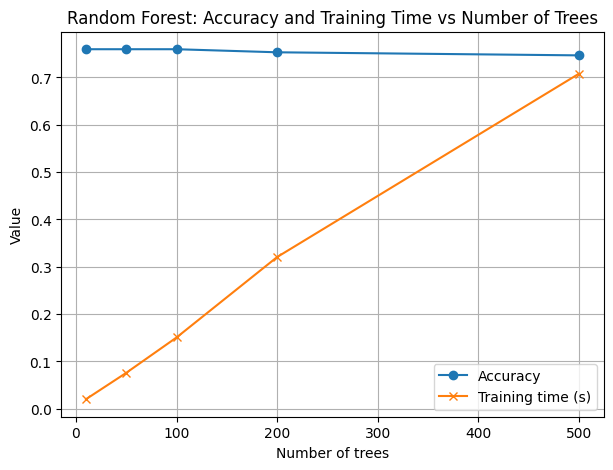

In [19]:
plt.figure(figsize=(7,5))
plt.plot(n_trees, acc_scores_nt, marker='o', label="Accuracy")
plt.plot(n_trees, train_times, marker='x', label="Training time (s)")
plt.xlabel("Number of trees")
plt.ylabel("Value")
plt.title("Random Forest: Accuracy and Training Time vs Number of Trees")
plt.legend()
plt.grid()
plt.show()

## 4) XGBoost

In [20]:
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [24]:
start_time = time.time()
xgb_clf.fit(X_train, y_train)
xgb_train_time = time.time() - start_time

y_pred_xgb = xgb_clf.predict(X_test)
metrics_xgb = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1": f1_score(y_test, y_pred_xgb),
    "ROC_AUC": roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
}

metrics_xgb_rounded = {k: round(v, 5) for k, v in metrics_xgb.items()}
print("\nXGBoost metrics:", metrics_xgb_rounded)
print("XGBoost training time (s):", xgb_train_time)


XGBoost metrics: {'Accuracy': 0.75325, 'Precision': 0.66667, 'Recall': 0.59259, 'F1': 0.62745, 'ROC_AUC': 0.82722}
XGBoost training time (s): 0.06039261817932129


## 5) Сводная таблица для Random Forest с оптимальными параметрами

In [25]:
best_rf = RandomForestClassifier(
    max_depth=best_depth,
    max_features=best_mf,
    n_estimators=100,
    random_state=42
)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])
}

metrics_rf_rounded = {k: round(v, 5) for k, v in metrics_rf.items()}
print("\nRandom Forest metrics:", metrics_rf_rounded)


Random Forest metrics: {'Accuracy': 0.75974, 'Precision': 0.67347, 'Recall': 0.61111, 'F1': 0.64078, 'ROC_AUC': 0.81667}


## Вывод
1.         Random Forest демонстрирует чуть более высокую точность (Accuracy, Precision, F1),
2.         XGBoost выигрывает по ROC-AUC (качество ранжирования вероятностей) и быстрее обучается.
3.         Оба метода подходят для классификации диабета, выбор зависит от приоритетов: скорость и ранжирование (XGBoost) или общая точность (Random Forest).